
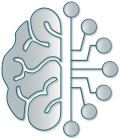

**Start at:** Sunday 16 June 2024, 11:34:01  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color, fg, bg, hl
vID.init(cwd0)

import tools4pyPhysChem as t4pPC

# Statistical treatment of data<br>(data science for beginners)<br><br>eXplainable AI (XAI)

<img width="25%" src="./DS4B-iris-images/ThinkerRodin-DallE.png" style="display:block; margin-left:auto; margin-right:auto" id="ThinkerByRodin"/>  

## Explainability with SHAP

<div class="rqT" title="Bogus notebook (after section 1.4) since keras 3.0"></div>

<div class="intro">

SHAP stands for **SH**apley **A**dditive ex**P**lanations. Shapley values are a way to explain the output of any machine learning model. It uses a game theoretic approach that measures each *player*'s contribution to the final outcome. One of the fundamental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present.

In a SHAP analyzis, each **feature** is assigned an **importance value** representing its **contribution to the model's output**.

SHAP values show how each feature affects each final prediction, the significance of each feature compared to others, and the model's reliance on the interaction between features

</div>

In [13]:
%matplotlib inline
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras

import shap

print(tf.__version__)
print(keras.__version__)

2.16.1
3.3.3


### Load the model, the scaler and the iris training and test datasets

<div class="intro">

First load the ANN model trained previously with the [iris3](./DS4B-Iris3.ipynb) notebook, as well as the scaler and the unstandardized datas used to train and test this ANN model.

<p style="text-align: center"><img width="250px" src="./DS4B-svg/ANN-petals.png" style="margin-left:auto; margin-right:auto" id="img_ANNWL"/></img></p> 

The model takes two parameters as input, the width *W*<sub>P</sub> and length *L*<sub>P</sub> of the petals, and it returns three probabilities $\mathcal{P}_{i}$, in the order <span style="color:#5b749d">setosa</span>, <span style="color:#bd7247">versicolor</span>, <span style="color:#499059">virginica</span>. The sum of probabilities is 1: $\sum_{i=1}^{3}\mathcal{P}_{i}=1$

Before assessing the trained ANN model, let's first load it, as well as the scaler. We will then remind the model architecture as well as the number of underlying parameters (the weights of the neuronal connections and the biases) 
</div>

/home/romuald/Python3/ML/lib64/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hLayer1 (Dense)                 │ (None, 7)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hLayer2 (Dense)                 │ (None, 5)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oLayer (Dense)                  │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239 (960.00 B)

 Trainable params: 79 (316.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160 (644.00 B)

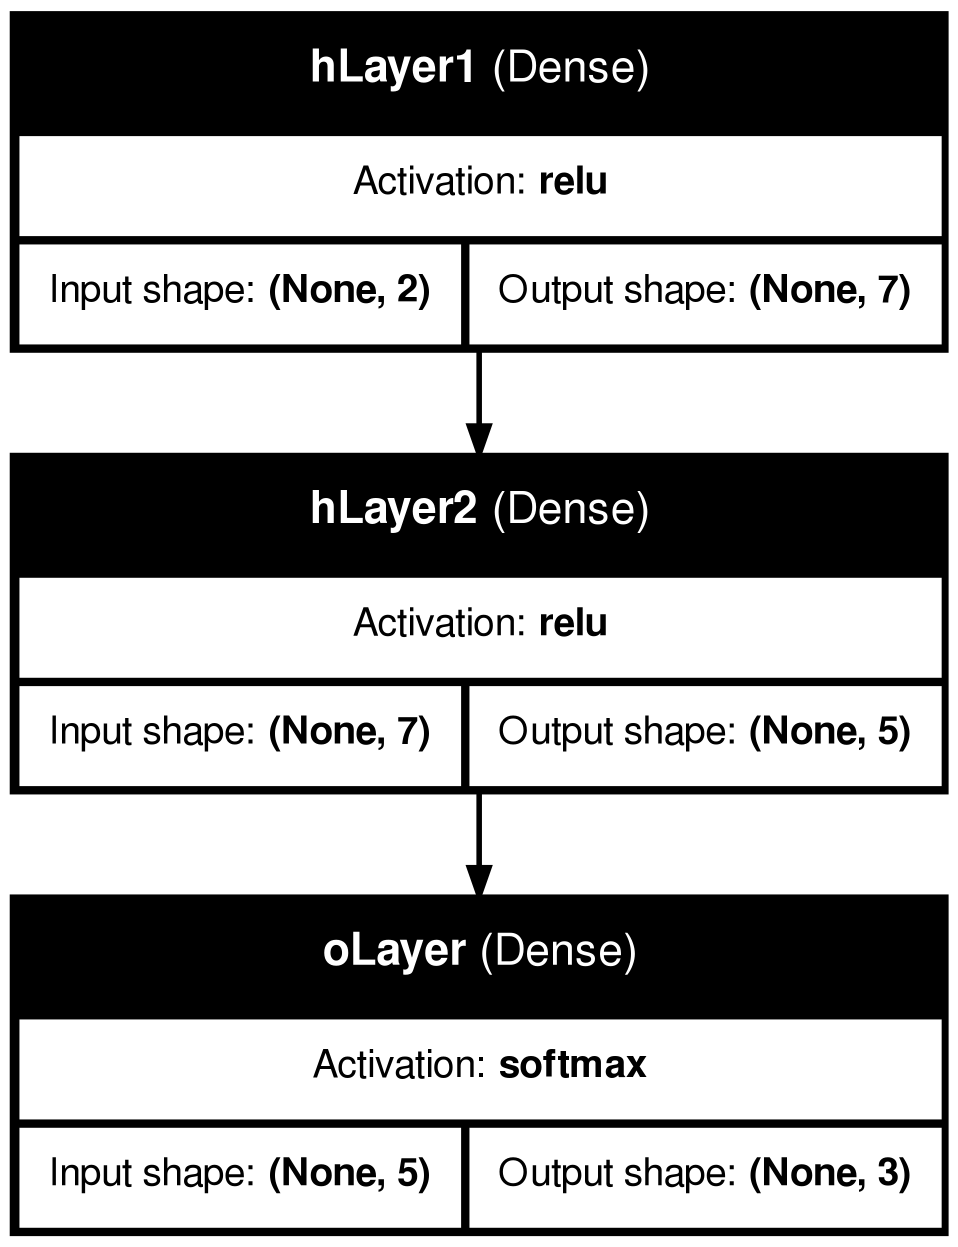

In [3]:
# load the model and the scaler
IrisANNmodel = tf.keras.models.load_model('./DS4B-Iris-SavedModels/ANNmodel-Iris-savedForIris4.keras')
import pickle
scaler = pickle.load(open("./DS4B-Iris-SavedModels/scaler_Iris-savedForIris4.pkl", 'rb'))

# Show the model architecture
IrisANNmodel.summary()

# plot the model
from tensorflow.keras.utils import plot_model
plot_model(IrisANNmodel, show_shapes=True, show_layer_names=True, show_layer_activations=True)


<div class="rq">

Now load the data used to train and test the optimized ANN model
</div>

In [4]:
data_train = pd.read_pickle('./DS4B-Iris-SavedModels/Iris-data_train-savedForIris4.pkl')
data_test = pd.read_pickle('./DS4B-Iris-SavedModels/Iris-data_test-savedForIris4.pkl')
display(data_train)
display(data_test)

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
82,5.8,2.7,3.9,1.2,versicolor,0.0,1.0,0.0
27,5.2,3.5,1.5,0.2,setosa,1.0,0.0,0.0
6,4.6,3.4,1.4,0.3,setosa,1.0,0.0,0.0
48,5.3,3.7,1.5,0.2,setosa,1.0,0.0,0.0
41,4.5,2.3,1.3,0.3,setosa,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
35,5.0,3.2,1.2,0.2,setosa,1.0,0.0,0.0
77,6.7,3.0,5.0,1.7,versicolor,0.0,1.0,0.0
68,6.2,2.2,4.5,1.5,versicolor,0.0,1.0,0.0
76,6.8,2.8,4.8,1.4,versicolor,0.0,1.0,0.0


,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
4,5.0,3.6,1.4,0.2,setosa,1.0,0.0,0.0
13,4.3,3.0,1.1,0.1,setosa,1.0,0.0,0.0
14,5.8,4.0,1.2,0.2,setosa,1.0,0.0,0.0
16,5.4,3.9,1.3,0.4,setosa,1.0,0.0,0.0
22,4.6,3.6,1.0,0.2,setosa,1.0,0.0,0.0
23,5.1,3.3,1.7,0.5,setosa,1.0,0.0,0.0
33,5.5,4.2,1.4,0.2,setosa,1.0,0.0,0.0
36,5.5,3.5,1.3,0.2,setosa,1.0,0.0,0.0
38,4.4,3.0,1.3,0.2,setosa,1.0,0.0,0.0
46,5.1,3.8,1.6,0.2,setosa,1.0,0.0,0.0


<div class="rqE">

Training and test datas must standardized before any input to the ANN model
</div>

In [5]:
class_names = ['setosa','versicolor','virginica']
features = ['petal_length','petal_width']

x_trainS = scaler.transform(data_train[features].values)
# print(x_trainS)
# print(x_trainS.shape)
x_train = pd.DataFrame(x_trainS, columns=data_train[features].columns, index=data_train.index)
y_train = data_train[class_names]
x_train_unscaled = data_train[features]

x_testS = scaler.transform(data_test[features].values)
x_test = pd.DataFrame(x_testS, columns=data_test[features].columns, index=data_test.index)
y_test = data_test[class_names]
x_test_unscaled = data_test[features]

display(x_train)
display(y_train)

,petal_length,petal_width
82,0.066996,-0.013243
27,-1.321115,-1.337504
6,-1.378953,-1.205078
48,-1.321115,-1.337504
41,-1.436791,-1.205078
...,...,...
35,-1.494629,-1.337504
77,0.703213,0.648888
68,0.414023,0.384036
76,0.587537,0.251610


,setosa,versicolor,virginica
82,0.0,1.0,0.0
27,1.0,0.0,0.0
6,1.0,0.0,0.0
48,1.0,0.0,0.0
41,1.0,0.0,0.0
...,...,...,...
35,1.0,0.0,0.0
77,0.0,1.0,0.0
68,0.0,1.0,0.0
76,0.0,1.0,0.0


### Brief reminder of the performance of the model and of the data

<div class="intro">

Just to get a basic impression of the model on one hand and of the data on the other hand, it is recommended viewing the confusion matrix, as well as the previous global analysis of the natural clustering of the **raw** data
    
<p style="text-align: center"><img width="1000px" src="./DS4B-svg/Iris3-ConfusionMatrix-petals.png" style="margin-left:auto; margin-right:auto" id="img_cm"/></img></p>

<p style="text-align: center"><img width="900px" src="DS4B-svg/jointplot_petals-sepals_classification.png" style="margin-left:auto; margin-right:auto" id="img_jpc"/></img></p>

</div>
<br>
<div class="rqE">

From the graph on the left
- setosa has the smallest petals, whilst virginica has the largest ones
- from the same petal graph, you can see the overlap between versicolor and virginica
</div>

### Plotting of "probability maps"

<div class="intro">

**This is not SHAP... yet**. But is is interesting to **assess and understand as much as possible the behaviour of the model** over a wide **hypothetical range of petal lengths and widths**. As an example, what will the model predict for flowers with very wide and short petals? 

In the following, we will plot three probability maps, one per species, in the 0 to 3 cm petal width and 0 to 8 cm petal lengths domain. Given what we have learnt from the *petal_length = f(petal_width)* graph, we, as human beings, would return the following probabilities, with a confidence index that decreases at the borders of the usual observations of the dimensions of iris species:

<p style="text-align: center"><img width="450px" src="DS4B-svg/jointplot_petals_classificationByHumanBeings.png" style="margin-left:auto; margin-right:auto" id="img_HumanClassif"/></img></p>

</div>

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step


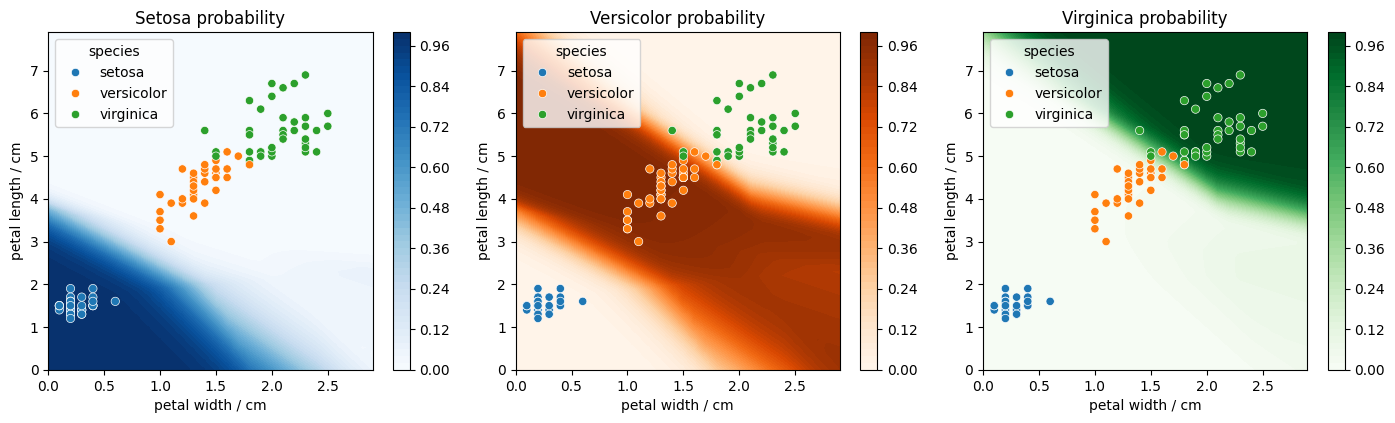

In [6]:
# first, create all possible tuples of petal lengths and widths in their respective domains [0,3]cm and [0,8]cm
petal_w = np.arange(0,3,0.1)
petal_l = np.arange(0,8,0.1)

petal_mesh = []
for pl in petal_l:
    for pw in petal_w:
        petal_mesh.append([pl,pw])

petal_mesh=np.array(petal_mesh)

# don't forget to standardize the mesh
petal_meshS = scaler.transform(petal_mesh)
# make the predictions for each (pl,pw) couple of the mesh
proba = IrisANNmodel.predict(petal_meshS)
probaSetosa = proba[:,0].reshape((len(petal_l),len(petal_w)))
probaVersicolor = proba[:,1].reshape((len(petal_l),len(petal_w)))
probaVirginica = proba[:,2].reshape((len(petal_l),len(petal_w)))

# let's plot now the predicted probabilities for each iris species

pw2D,pl2D = np.meshgrid(petal_w,petal_l)
# print(pl2D.shape,pw2D.shape)
# print(pw2D)
# print(pl2D)
cm = 1/2.54
ncols = 3
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*12*cm, nrows*11*cm))
plt.subplot(nrows, ncols, 1)
c0 = axs[0].contourf(pw2D, pl2D, probaSetosa,levels=50,cmap='Blues')
_ = fig.colorbar(c0)
axs[0].set_xlabel("petal width / cm")
axs[0].set_ylabel("petal length / cm")
axs[0].set_title("Setosa probability")
sns.scatterplot(x = "petal_width", y = "petal_length", data = data_train, hue="species",hue_order=class_names)

plt.subplot(nrows, ncols, 2)
c1 = axs[1].contourf(pw2D, pl2D, probaVersicolor,levels=50,cmap='Oranges')
_ = fig.colorbar(c1)
axs[1].set_xlabel("petal width / cm")
axs[1].set_ylabel("petal length / cm")
axs[1].set_title("Versicolor probability")
sns.scatterplot(x = "petal_width", y = "petal_length", data = data_train, hue="species",hue_order=class_names)

plt.subplot(nrows, ncols, 3)
c2 = axs[2].contourf(pw2D, pl2D, probaVirginica,levels=50,cmap='Greens')
_ = fig.colorbar(c2)
axs[2].set_xlabel("petal width / cm")
axs[2].set_ylabel("petal length / cm")
axs[2].set_title("Virginica probability")
sns.scatterplot(x = "petal_width", y = "petal_length", data = data_train, hue="species",hue_order=class_names)

plt.tight_layout()
plt.show()


<div class="rqT" title="Comment">

Given the blue, orange and green zones that correspond to high probabilities , the model is clearly able to separate the three species, but is is unable to reduce the classification domains to the zones highlighted by the <span style="color:#5b749d">blue</span>, <span style="color:#bd7247">orange</span> and <span style="color:#499059">green</span> scatter points. 

This is problematic if you ask the model which species would belong to an hypothetical iris which features are (petal width = 2.5 cm, petal length = 1 cm). **It will identify a virginica, whereas the answer "*it's very unlikely that this is one of the three iris species I am aware of*" would be more appropriate**

**It cannot be otherwise**, since the model returns *three probabilities* which sum must be equal to one for any (petal width, petal length) tuple: $\sum_{i=1}^{3}\mathcal{P}_{i}=1$. In other words, there is no fourth "not an iris" probability

Could it be wise to identify "*uncharted territories*", and to introduce some representative points belonging to this domain in the training set, with a fourth "*unknown species*" class? May be in this case, but in general it is *by definition* not possible to identify uncharted territories and their limits.
</div>

<div class="intro">

To go deeper into the analysis and introduce the concept of **decision boundary**, let's now use a contour plot to represent the three probabilities on the same graph, with a small number of contour lines. 
</div>

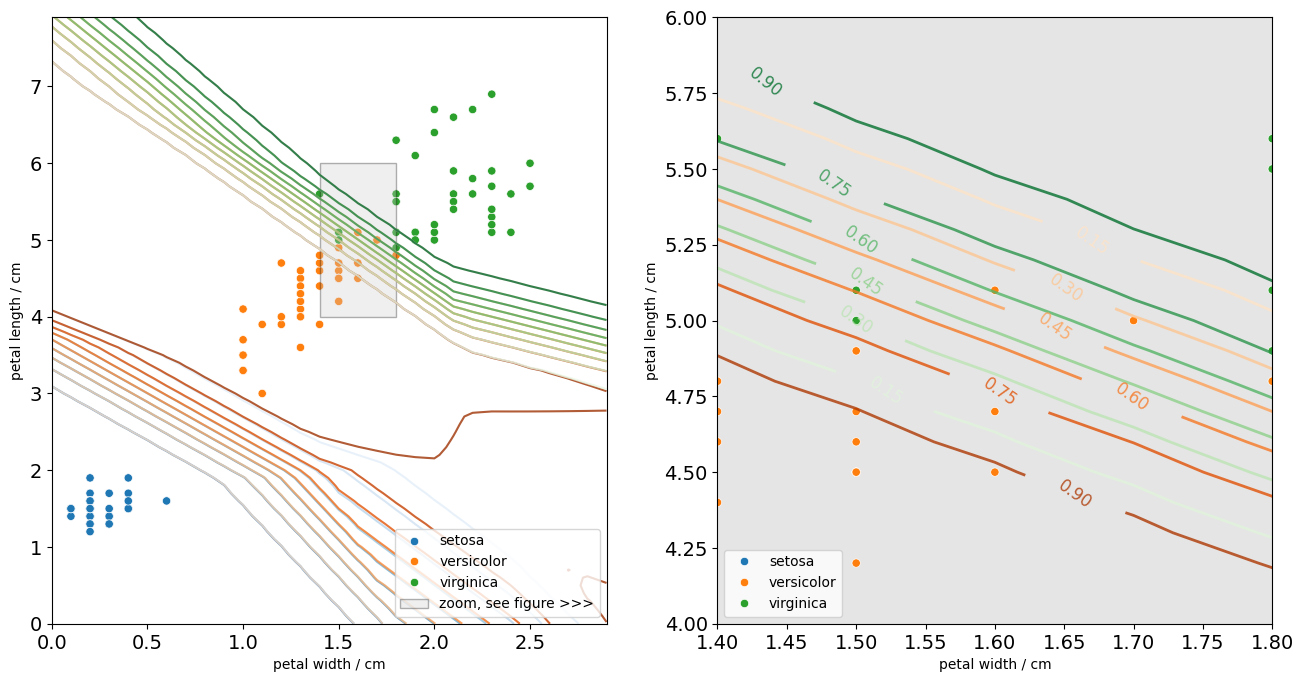

In [7]:
ncols = 2
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*20*cm, nrows*20*cm))
plt.subplot(nrows, ncols, 1)
plt.tick_params(axis='x',labelsize = 14)
plt.tick_params(axis='y',labelsize = 14)
c0 = axs[0].contour(pw2D, pl2D, probaSetosa,levels=10,cmap='Blues',alpha=0.8)
c1 = axs[0].contour(pw2D, pl2D, probaVersicolor,levels=10,cmap='Oranges',alpha=0.8)
c2 = axs[0].contour(pw2D, pl2D, probaVirginica,levels=10,cmap='Greens',alpha=0.8)
axs[0].set_xlabel("petal width / cm")
axs[0].set_ylabel("petal length / cm")
sns.scatterplot(x = "petal_width", y = "petal_length", data = data_train, hue="species",hue_order=class_names)
from matplotlib.patches import Rectangle
xbox1 = 1.4
xbox2 = 1.8
ybox1 = 4.0
ybox2 = 6.0
my_gray=(0.8, 0.8, 0.8, 0.5)
axs[0].add_patch(Rectangle((xbox1, ybox1), xbox2-xbox1, ybox2-ybox1, edgecolor='black', facecolor=my_gray,label="zoom, see figure >>>",alpha=0.3))
plt.legend(loc='lower right',fontsize=10)

plt.subplot(nrows, ncols, 2)
plt.tick_params(axis='x',labelsize = 14)
plt.tick_params(axis='y',labelsize = 14)
c1 = axs[1].contour(pw2D, pl2D, probaVersicolor,levels=6,cmap='Oranges',alpha=0.8, linewidths=2)
manual_locations = [(1.65, 4.4), (1.70, 4.75), (1.6, 4.75), (1.65, 5.), (1.65, 5.1), (1.65, 5.2)]
plt.clabel(c1, inline=True, fontsize=12, manual=manual_locations,inline_spacing=-10)
c2 = axs[1].contour(pw2D, pl2D, probaVirginica,levels=6,cmap='Greens',alpha=0.8, linewidths=2)
manual_locations = [(1.5, 6), (1.5, 5.5), (1.5, 5.25),(1.5, 5.1), (1.5, 5),  (1.5, 4.7)]
plt.clabel(c2, inline=True, fontsize=12, manual=manual_locations,inline_spacing=-10)
axs[1].set_xlim([xbox1,xbox2])
axs[1].set_ylim([ybox1,ybox2])
axs[1].set_xlabel("petal width / cm")
axs[1].set_ylabel("petal length / cm")
axs[1].set_facecolor(my_gray)
sns.scatterplot(x = "petal_width", y = "petal_length", data = data_train, hue="species",hue_order=class_names)

plt.legend(loc='lower left',fontsize=10)

plt.show()

<div class="rqT" title="Comment: decision boundaries">

Analyze the graph on the left: there is an overlap between all probability domains. These overlap domains are named <span style='color:red'>**decision boundaries**</span>:
- a decision boundary is a hypersurface in machine learning that delineates the boundaries of classes - the three iris species in the present case
- the decision boundary between <span style="color:#bd7247">versicolors</span> and <span style="color:#499059">virginicas</span> is shown in the right-hand subplot, with probability values reported on the contour lines. The green and orange 0.6 contour lines show where the model will not be very confident in the identification of <span style="color:#499059">virginica</span> and <span style="color:#bd7247">versicolor</span> irises
- it has no consequence to distinguish <span style="color:#5b749d">setosa</span> and <span style="color:#499059">virginica</span> species, given the large separation between their respective petal dimensions
- the overlap between blue lines (<span style="color:#5b749d">setosa</span>) and green lines (<span style="color:#499059">virginica</span>), *i.e.* the co-existence domain of competing probabilities, lies only at the bottom of the graph, for petal widths between 1.0 and 1.5 cm, a domain where no actual <span style="color:#499059">virginica</span> flowers can be encountered  
</div>

<div class="rqT" title="Comment: classification vs. clustering">

**Classification vs. clustering?** Although both techniques have certain similarities, the difference lies in the fact that **classification** uses **predefined classes** in which objects are assigned, while **clustering** **identifies similarities** between objects, which it groups according to those characteristics in common and which differentiate them from other groups of objects. These groups are known as "clusters". Classification relies on predefined labels and a supervisor to guide the learning process. On the other hand, clustering operates without a supervisor and is more exploratory. The figure below illustrates the difefrence between the two

<p style="text-align: center"><img width="750px" src="./DS4B-svg/clustering_vs_classification/clustering-vs-classification.png" style="margin-left:auto; margin-right:auto" id="img_clust-vs-classif"/></img></p> 

To some extent the algorithm has discovered the relationship between petal sizes and iris species. The probability maps demonstrate that the models makes a kind of clustering. But it is not perfect.    
</div>

### SHAP: first apply the `DeepExplainer` algorithm

<div class="intro">

It is an explainability technique that can be used for models with a neural network based architecture. This is the fastest neural network explainability approach and is based on running a SHAP-based version of the original Deep Learning Important FeaTures (DeepLIFT) algorithm.

`DeepExplainer` is the primary option, but it is possinle to check the other core explainers as well. For example, the `KernelExplainer` can be used on any model and thus, could also be an option on Deep Learning models

</div>

In [29]:
# select a set of background examples to take an expectation over
background = x_train.copy()
print(background.shape,type(background))
dummy = background.to_numpy()
dummy = np.array(dummy)
print(dummy.shape,type(dummy))
print(type(IrisANNmodel))
print(IrisANNmodel.layers[0].input)
# dummy = background.to_numpy()
# print(dummy.shape)
# print(type(dummy.shape))
# print(np.array(dummy.shape))
# print(np.array(dummy.shape).as_list())
# deep_explainer = shap.DeepExplainer(IrisANNmodel, dummy)
deep_explainer = shap.DeepExplainer((IrisANNmodel.layers[0].input,IrisANNmodel.layers[-1].input), background)
shap_values_train = deep_explainer.shap_values(x_train.values)

print(deep_explainer.expected_value)


(120, 2) <class 'pandas.core.frame.DataFrame'>
(120, 2) <class 'numpy.ndarray'>
<class 'keras.src.models.sequential.Sequential'>


AttributeError: 'KerasTensor' object has no attribute 'as_list'

### SHAP summary plots

<div class="intro">

In the next plot, the impact of a feature on the three iris classes is stacked to create the feature importance plot. If some features can differentiate a particular class from the rest, that is the plot where you can see it. In other words, the summary plot for multiclass classification can show you what the machine managed to learn from the features.

</div>

In [9]:
t4pPC.centerTitle("Train")
shap.summary_plot(shap_values_train,x_train, feature_names=features,class_names=class_names,sort=False,plot_type="bar")

NameError: name 'shap_values_train' is not defined

<div class="rqE">

It is not suprising that in this case, the two features are used equally to classify iris flowers to the three classes. It will be interesting to do the same analysis with the four features used to classify irises. 

</div>

<div class="intro">

You can also see the summary plot of a specific class.

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance, *i.e.* a sample.

Let's visualize it on `class[0]`, *i.e.* the setosa class
</div>

In [10]:
shap.summary_plot(shap_values_train[0],x_train)

NameError: name 'shap_values_train' is not defined

<div class="rqE">

Both features are important to classify irises as setosas. `petal_length` either causes a large negative or positive change in the prediction. From the right scale, it is seen that red and blue represent large and small feature values, respectively. The summary plot tells us that small `petal_length` values increase the prediction, wheras large values decrease the prediction. 
</div>

<div class="intro">

We will now plot summary plots as violin plots, for all classes,  with outliers drawn as points.
</div>

In [11]:
t4pPC.centerTitle(f"Train. Successive summary plots for {class_names}")
# setosa
shap.summary_plot(shap_values_train[0],x_train, plot_type="violin")
# versicolor
shap.summary_plot(shap_values_train[1],x_train, plot_type="violin")
# virginica
shap.summary_plot(shap_values_train[2],x_train, plot_type="violin")

NameError: name 'shap_values_train' is not defined

<div class="rqE">

We see the first indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, we have to look at SHAP dependence plots
</div>

### Dependence plots

<div class="intro">

A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic, or more complex

- the x-axis is the actual value from the dataset
- the y-axis is the SHAP value for that feature, which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction
- the color corresponds to a second feature that may have an interaction effect with the feature we are plotting
- each dot is a single prediction

</div>

In [ ]:
shap.dependence_plot(0, shap_values_train[0], x_train_unscaled)

<div class='rqE'>

So what?

</div>

### Explain predictions

<div class="intro">

First use the ANN model to predict the class affiliation for all samples of the training and test sets.
</div>

In [ ]:
y_train_hat=IrisANNmodel.predict(x_train.values) #returns a numpy array
#print(y_train_hat)
y_test_hat=IrisANNmodel.predict(x_test.values)
sample = 6
t4pPC.centerTitle(f"Sample {sample}")
print(f"  Prediction = {y_train_hat[sample]}")
print(f"Actual value = {y_train.to_numpy()[sample]}")

#### Explain a single prediction with SHAP force plots

<div class="intro">

Force plot gives us the explainability of a single model prediction. In this plot, we can see how features contributed to the model’s prediction for a specific observation. It is very convenient to use for error analysis or a deep understanding of a particular case

We also see which features have a <span style='color:red'>positive</span> or <span style='color:blue'>negative</span> impact on "base value" prediction and the magnitude of the impact
</div>

In [ ]:
def multi_force_plot(sample_index):
    shap.initjs()
    print(f"{bg.LIGHTREDB}Sample {sample_index} is actually a {class_names[np.argmax(y_train.to_numpy()[sample_index])]}{fg.OFF}")
    print()
    for iclass, nclass in enumerate(class_names):
        t4pPC.centerTitle(f"{nclass} prediction for sample {sample_index}")
        display(shap.force_plot(deep_explainer.expected_value[iclass].numpy(), shap_values_train[iclass][sample_index], features = features))

multi_force_plot(sample)

<div class="rqE">

- the ANN model predicts a 0.99 probability value that the flower is a setosa (see also the application of `IrisANNmodel.predict(x_test.values)`)
- the base value is the value that would be predicted if we didn’t know any features for the current instance. The base value is the average of the model output over the training dataset (`explainer.expected_value` in the code). In this example, the base value = 0.3405 for setosas.
- the numbers on the plot arrows are the value of the feature for this instance (or sample)
- <span style='color:red'>red</span> represents features that increase the probability the model score higher, and <span style='color:blue'>blue</span> represents features that lower the probability
- the wider the arrow, the bigger the impact of the feature on the output. The amount of decrease or increase in the impact can be seen on the x-axis.
- both features, i.e. the petal lengths and withs, contribute to increase the probability that sample 0 is a setosa species
</div>

<div class="ex" title="Analyze another prediction">

Do the same for the fourth sample of the training set.

Comments ? You can answer in light of the hue scatter plot shown hereafter
</div>

In [ ]:
# insert your code here



<div class="sol">

Want to see a possible answer? Uncomment the `# %load ./SolutionsToExercises/...` command below, and then run the cell
</div>

In [ ]:
# %load ./SolutionsToExercises/DS4B/Iris4a.py


In [ ]:
selected_sample = 3
pl_sample = data_train.iloc[selected_sample]["petal_length"]
pw_sample = data_train.iloc[selected_sample]["petal_width"]

import seaborn as sns
g = sns.jointplot(x = "petal_width", y = "petal_length", data = data_train, hue="species", hue_order= class_names, s=48)
g.ax_joint.scatter(pw_sample, pl_sample, color = 'green', s=200, marker="D", alpha = 0.3, label=f"sample {selected_sample}")
plt.legend()
plt.show()

<div class="rqT" title="Quite interesting this prediction analyzis!">

Do you agree?
</div>

#### Explain a single prediction with SHAP waterfall plots

<div class="intro">

The waterfall plot is another local analysis plot of a single instance prediction. It does not differ much from the previous analysis. 
</div>

In [ ]:
iclass = 0
sample_index = 0

shap.waterfall_plot(shap.Explanation(values=shap_values_train[iclass][sample_index], 
                                     base_values=deep_explainer.expected_value[iclass].numpy(), data=x_train.values[sample_index],  
                                     feature_names=features))

In [ ]:
def multi_waterfall_plot(sample_index):
    shap.initjs()
    print(f"{bg.LIGHTREDB}Sample {sample_index} is actually a {class_names[np.argmax(y_train.to_numpy()[sample_index])]}{fg.OFF}")
    print()
    for iclass, nclass in enumerate(class_names):
        t4pPC.centerTitle(f"{nclass} prediction for sample {sample_index}")
        display(shap.waterfall_plot(shap.Explanation(values=shap_values_train[iclass][sample_index], 
                                     base_values=deep_explainer.expected_value[iclass].numpy(), data=x_train.values[sample_index],  
                                     feature_names=features)))

multi_waterfall_plot(sample)

#### Explain many predictions

<div class="intro">

Here we repeat the above explanation process for 50 individuals. Since we are using a sampling based approximation each explanation can take a couple seconds depending on your machine setup
</div>

In [ ]:
def many_predictions_plot(nsamples):
    shap.initjs()
    selected_samples = np.random.choice(x_train.values.shape[0], size=50, replace=False, p=None)
    for iclass, nclass in enumerate(class_names):
        t4pPC.centerTitle(f"{nclass}")
        display(shap.force_plot(deep_explainer.expected_value[iclass].numpy(), shap_values_train[iclass][selected_samples], features = features))

many_predictions_plot(50)

<div class="rq">

In all cases, the petal length and width play an important role. 
</div>

## Conclusion

<div class="rq">

The SHAP framework has proved to be an important advancement in the field of machine learning model interpretation. 

SHAP combines several existing methods to create an intuitive, theoretically sound approach to explain predictions for any model.

SHAP values quantify the magnitude and direction (positive or negative) of a feature’s effect on a prediction

**XAI analysis with SHAP or other tools, as well as a preliminary analysis of the data should be an integral part of the machine learning framework**
</div>

## Bibliography

- [Explainable AI (XAI) on Wikipedia](https://en.wikipedia.org/wiki/Explainable_artificial_intelligence)
- [SHAP documentation](https://shap.readthedocs.io/en/latest/)
- [XAI with SHAP -Multi-Class Classification Problem](https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea)


In [ ]:
vID.end(cwd0)